## Import necessary packages

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import json
 
task = 'nq'
with open(f'../../collected_data/certain_uncertain_{task}.json', 'r') as f:
    lines = f.readlines()
# convert lines into pandas dataframe as a list of dicts
lines = [json.loads(line) for line in lines]
df_nq = pd.DataFrame.from_records(lines)

task = 'trivia'
with open(f'../../collected_data/certain_uncertain_{task}.json', 'r') as f:
    lines = f.readlines()
# convert lines into pandas dataframe as a list of dicts
lines = [json.loads(line) for line in lines]
df_trivia = pd.DataFrame.from_records(lines)

task = 'squad1'
with open(f'../../collected_data/certain_uncertain_{task}.json', 'r') as f:
    lines = f.readlines()
# convert lines into pandas dataframe as a list of dicts
lines = [json.loads(line) for line in lines]
df_squad1 = pd.DataFrame.from_records(lines)

df = pd.concat([df_nq, df_trivia, df_squad1])

# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values
print('number of positive labels: ', sum(labels))
print('number of negative labels: ', len(labels) - sum(labels))

number of positive labels:  3011
number of negative labels:  5613


In [7]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
        sent,                      # Sentence to encode.
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = 512,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True,   # Construct attn. masks.
        return_tensors = 'pt',     # Return pytorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
torch.manual_seed(42)
# Calculate the number of samples to include in each set.
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
val_dataset, test_dataset = random_split(val_dataset, [int(0.5*val_size), val_size-int(0.5*val_size)])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

device = torch.device('cuda:5' if torch.cuda.is_available() else 'cpu')

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import wandb
# WANDB PARAMETER
def ret_dataloader():
    # batch_size = wandb.config.batch_size
    batch_size = 32
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    test_dataloader = DataLoader(
                test_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader, validation_dataloader, test_dataloader

"""# Load Pre-trained BERT model"""

from transformers import BertForSequenceClassification, AdamW, BertConfig

def ret_model():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    return model

def ret_optim(model):
    # print('Learning_rate = ',wandb.config.learning_rate )
    learning_rate = 1e-5
    optimizer = AdamW(model.parameters(),
                      lr = learning_rate,
                      eps = 1e-8
                    )
    return optimizer

from transformers import get_linear_schedule_with_warmup

def ret_scheduler(train_dataloader,optimizer):
    # epochs = wandb.config.epochs
    epochs = 4
    print('epochs =>', epochs)
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

"""# The Train Function"""
import random
import numpy as np


Loading BERT tokenizer...


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length:  257


/home/lishuo1/anaconda3/envs/glu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/tmp/ipykernel_2560601/1058795086.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels)


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
"""# The Train Function"""
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
def train():
    # wandb.init(config=sweep_defaults)
    wandb.init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader, validation_dataloader, test_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader, optimizer)
    criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([3.0, 5.0], device=device))

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    # epochs = wandb.config.epochs
    epochs = 4
    best_val_accuracy = 0.0
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels)
            loss = criterion(outputs['logits'], b_labels)
            # loss, logits = outputs['loss'], outputs['logits']
            wandb.log({'train_batch_loss': loss.item()})
            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        wandb.log({'avg_train_loss':avg_train_loss})

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():

                outputs = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels)
                loss, logits = outputs['loss'], outputs['logits']

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy': avg_val_accuracy, 'avg_val_loss': avg_val_loss})
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

        if avg_val_accuracy > best_val_accuracy:
            # save best model
            best_val_accuracy = avg_val_accuracy
            torch.save(model.state_dict(), 'confidence_best_model_state.bin')

    print("")
    print("Training complete!")

    # Tracking variables
    total_test_accuracy = 0
    total_test_loss = 0
    # Evaluate data for one epoch
    for batch in test_dataloader:

        b_input_ids = batch[0].cuda()
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            outputs = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels)
            loss, logits = outputs['loss'], outputs['logits']

        # Accumulate the validation loss.
        total_test_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_test_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_test_accuracy / len(test_dataloader)
    print("Test  Accuracy: {0:.2f}".format(avg_val_accuracy))
    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [8]:
# Function to calculate the accuracy of our predictions vs labels
def flat_confidence(preds):
    predicted_confidence = torch.nn.functional.softmax(preds, dim=1)
    # take out the confidence of predicting "not answerable"
    return predicted_confidence[:,0].flatten()

Train = False
if Train:
    train()

# load in the best model
model = ret_model()
model.load_state_dict(torch.load('../../finetuned_models/confidence_best_model_state.bin'))
model = model.to(device)
# Put model in evaluation mode
model.eval()

# Load validation dataset
_, val_dataloader, test_dataloader = ret_dataloader()

# Tracking variables
total_test_accuracy = 0
total_test_loss = 0
# Evaluate data for one epoch

predicted_logits = []
labels = []

for batch in val_dataloader:

    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels)
        loss, logits = outputs['loss'], outputs['logits']

    # Accumulate the validation loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predicted_logits.extend(logits)
    labels.extend(label_ids)

    total_test_accuracy += flat_accuracy(logits, label_ids)

for batch in test_dataloader:

    b_input_ids = batch[0].cuda()
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # Tell pytorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training).
    with torch.no_grad():

        outputs = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels)
        loss, logits = outputs['loss'], outputs['logits']

    # Accumulate the validation loss.
    total_test_loss += loss.item()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    predicted_logits.extend(logits)
    labels.extend(label_ids)

    total_test_accuracy += flat_accuracy(logits, label_ids)

# Report the final accuracy for this validation run.
avg_val_accuracy = total_test_accuracy / (len(test_dataloader) + len(val_dataloader))
print("Test  Accuracy: {0:.2f}".format(avg_val_accuracy))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
predicted_confidence = flat_confidence(torch.tensor(predicted_logits)).numpy()
labels = torch.tensor(labels).numpy()

/tmp/ipykernel_734667/2070009724.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  predicted_confidence = flat_confidence(torch.tensor(predicted_logits)).numpy()


In [ ]:
confidences = [] 
confidences_answered = []
for confidence, label in zip(predicted_confidence, labels):
    if label == 0:
        confidences.append(confidence)
    else:
        confidences_answered.append(confidence)

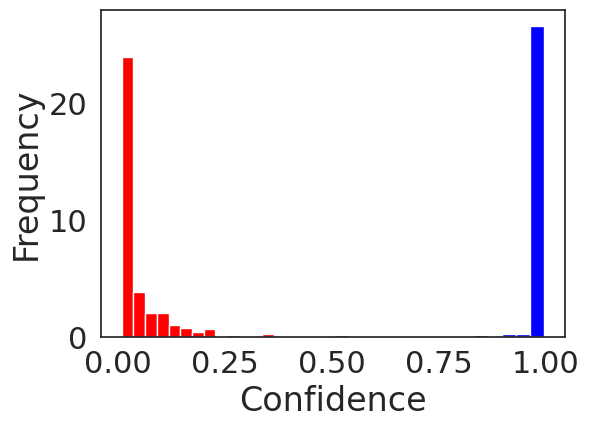

In [ ]:
plt.hist(confidences, density=True, bins=30, color='blue')  # density=False would make counts
plt.hist(confidences_answered, density=True, bins=30, color='red') 
plt.ylabel('Frequency')
plt.xlabel('Confidence')
plt.tight_layout()
plt.savefig('../collected_plots/conf_dist.png')

In [97]:
import utils
import pandas as pd

In [ ]:
indices = np.arange(len(confidences))
random.shuffle(indices)
cal_indices = indices[:int(len(indices) * 0.5)]
test_indices = indices[int(len(indices) * 0.5):]

cal_confidences = utils.split(confidences, cal_indices)
test_confidences = utils.split(confidences, test_indices)

In [ ]:
results = []
results_answered = []
for seed in [10, 20, 30, 40, 50]:
    tmp = {}
    tmp_answered = {}
    random.seed(seed)
    indices = np.arange(len(confidences))
    random.shuffle(indices)
    cal_indices = indices[:int(len(indices) * 0.5)]
    test_indices = indices[int(len(indices) * 0.5):]
    tmp['seed'] = seed
    tmp_answered['seed'] = seed

    cal_confidences = utils.split(confidences, cal_indices)
    test_confidences = utils.split(confidences, test_indices)
    for alpha in [0.1, 0.2, 0.3, 0.4, 0.5]:
        thr = np.quantile(cal_confidences, q=alpha, method='lower')
        coverage = np.mean(test_confidences >= thr)
        tmp_answered[1-alpha] = np.mean(confidences_answered >= thr)
        tmp[1-alpha] = coverage

    results.append(tmp)
    results_answered.append(tmp_answered)

In [ ]:
df = pd.DataFrame.from_records(results)
del(df['seed'])

/home/lishuo1/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lishuo1/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lishuo1/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/lishuo1/.local/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


Text(0.5, 1.0, 'Expected vs Empirical Coverage')

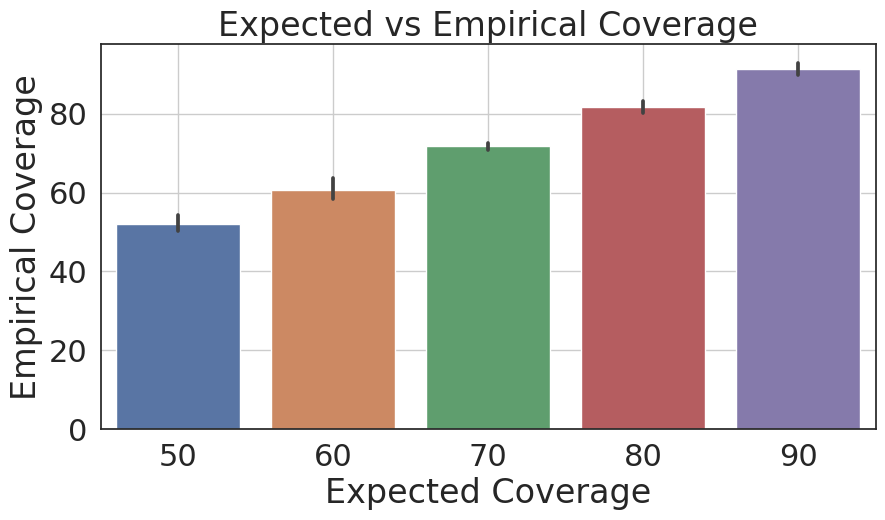

In [ ]:
# plot the results with error bar
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='white', font_scale=2)
# sns.set(font_scale=2)
# plt.rcParams.update({'font.size': 1}) # must set in top
# transpose the dataframe

# sns.set_theme(style="whitegriad", as_cmap=True)
plt.figure(figsize=(10, 5))
# reorder the columns
df = df[[0.5, 0.6, 0.7, 0.8, 0.9]]
df.columns = ['50', '60', '70', '80', '90']
df = df * 100
sns.color_palette("tab10", as_cmap=True)
ax = sns.barplot(data=df)
plt.grid()
ax.set_xlabel('Expected Coverage')
ax.set_ylabel('Empirical Coverage')
ax.set_title('../../collected_plots/Expected vs Empirical Coverage')


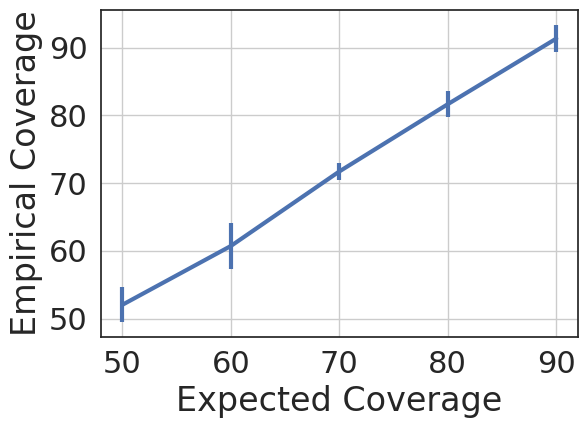

In [ ]:
df_mean = df.mean()
df_err = df.std()
df_mean.plot(yerr=df_err, linewidth=3)
plt.grid()
plt.xlabel('Expected Coverage')
plt.ylabel('Empirical Coverage')
plt.tight_layout()
plt.savefig('../../collected_plots/uncertainty.png')

In [ ]:
df = pd.DataFrame.from_records(results_answered)
del(df['seed'])

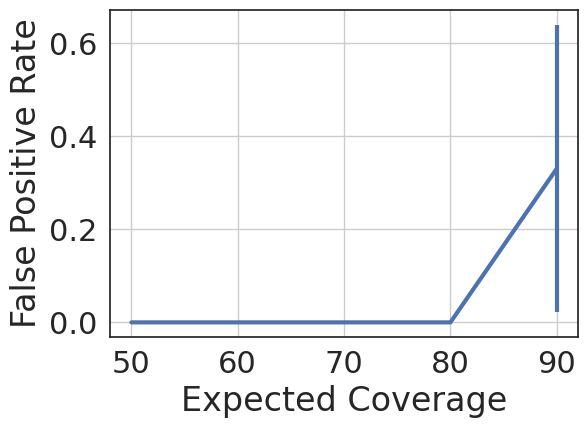

In [ ]:
df = df[[0.5, 0.6, 0.7, 0.8, 0.9]]
df.columns = ['50', '60', '70', '80', '90']
df = df * 100
df_mean = df.mean()
df_err = df.std()
df_mean.plot(yerr=df_err, linewidth=3)
plt.grid()
plt.xlabel('Expected Coverage')
plt.ylabel('False Positive Rate')
plt.tight_layout()
plt.savefig('../../collected_plots/fpr.png')